In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

### Step 1: Data Reading 

In [46]:
df = pd.read_csv('../data/bank_transactions_data.csv') 

In [47]:
df.shape

(2512, 16)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [49]:
df.columns

Index(['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
       'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID',
       'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate'],
      dtype='object')

In [50]:
# fix column names: remove spaces from name 
df.columns = [col.replace(" ", "") for col in df.columns]

In [51]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [52]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IPAddress,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


### Step 2: Data Cleaning & Profiling

#### 2.1 Check nulls and duplicates

In [53]:
# check nulls
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IPAddress                  0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

In [54]:
# check duplicate records 
df.duplicated().sum()

np.int64(0)

#### 2.2 Check counts of categorical fields

In [55]:
categorical_cols = df.select_dtypes(exclude='number').columns.tolist()

for col in categorical_cols:
    print(col, df[col].nunique())

TransactionID 2512
AccountID 495
TransactionDate 2512
TransactionType 2
Location 43
DeviceID 681
IPAddress 592
MerchantID 100
Channel 3
CustomerOccupation 4
PreviousTransactionDate 360


No obvious data issues, and the distribution of unique values makes sense:No apparent data quality issues, and the uniqueness of values appears reasonable:
1. Columns like TransactionID, TransactionDate, DeviceID, IP Address are mostly identifiers, and we will not be used as direct input features for the ML algorithms.
2. Categorical columns (TransactionType, Location, Channel, CustomerOccupation) can be used as input features for the ML algorithms after the appropriate encoding.

#### 2.3 Check & fix date fields
The date fields were read as “object” type and need to be converted to the datetime category.

In [56]:
# check the columns with "date" in their name and their data type 
date_cols = [col for col in df.columns if "date" in col.lower()]
print(df[date_cols].dtypes)

TransactionDate            object
PreviousTransactionDate    object
dtype: object


In [57]:
# convert date fields to correct formats
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
print(df[date_cols].dtypes)

TransactionDate            datetime64[ns]
PreviousTransactionDate    datetime64[ns]
dtype: object


### Step 3: Exploratory Data Analysis (EDA)

In [58]:
# check basic stats
df.describe()

,TransactionAmount,TransactionDate,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
count,2512.000000,2512,2512.000000,2512.000000,2512.000000,2512.000000,2512
mean,297.593778,2023-07-05 20:32:10.826433024,44.673965,119.643312,1.124602,5114.302966,2024-11-04 08:09:22.219745024
min,0.260000,2023-01-02 16:00:06,18.000000,10.000000,1.000000,101.250000,2024-11-04 08:06:23
25%,81.885000,2023-04-03 16:22:05.750000128,27.000000,63.000000,1.000000,1504.370000,2024-11-04 08:07:53
50%,211.140000,2023-07-07 17:49:43.500000,45.000000,112.500000,1.000000,4735.510000,2024-11-04 08:09:22
75%,414.527500,2023-10-06 18:40:53.500000,59.000000,161.000000,1.000000,7678.820000,2024-11-04 08:10:53.249999872
max,1919.110000,2024-01-01 18:21:50,80.000000,300.000000,5.000000,14977.990000,2024-11-04 08:12:23
std,291.946243,NaN,17.792198,69.963757,0.602662,3900.942499,NaN


#### 3.1 Numeric columns analysis
Generate descriptive statistics, visualize distributions, calculate skewness, detect outliers, and examine correlations between numeric columns.

In [59]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [60]:
# stats 
df[numeric_cols].describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


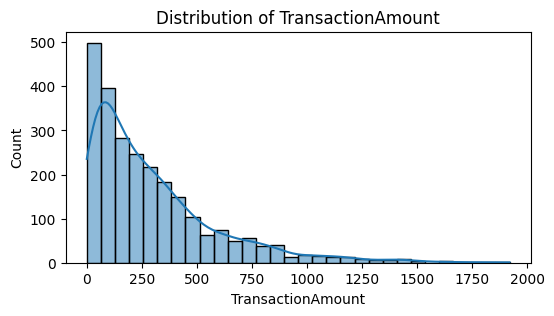

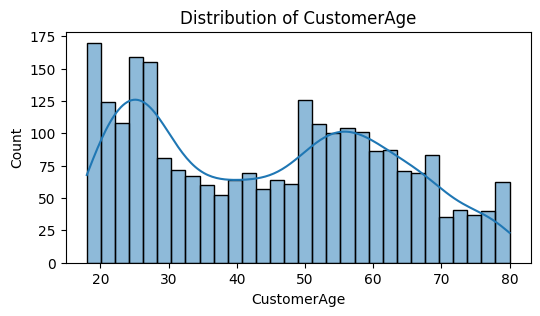

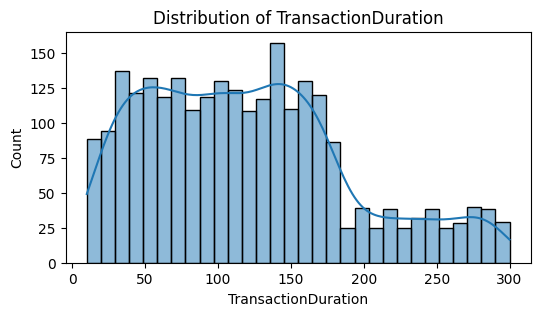

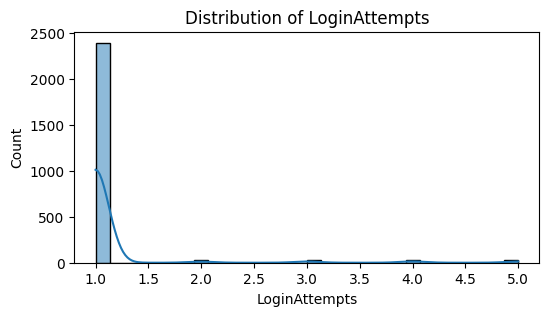

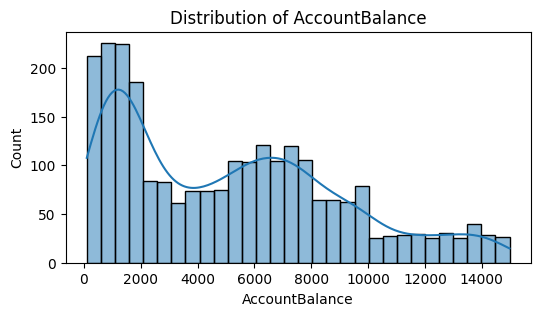

In [61]:
# histograms
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
# quantify the skewness of the distributions 
print("Skewness values for numeric columns:")
print(df[numeric_cols].skew())

Skewness values for numeric columns:
TransactionAmount      1.740107
CustomerAge            0.147864
TransactionDuration    0.599432
LoginAttempts          5.173491
AccountBalance         0.601201
dtype: float64


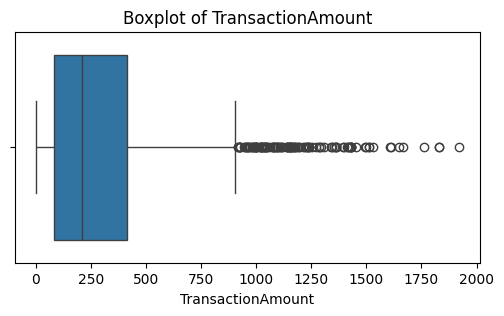

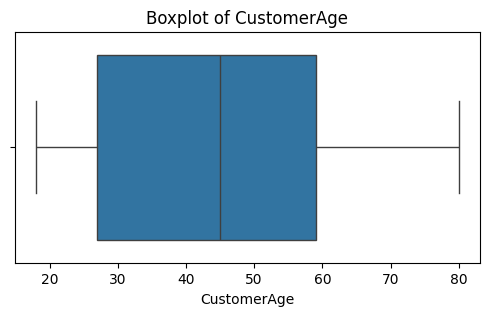

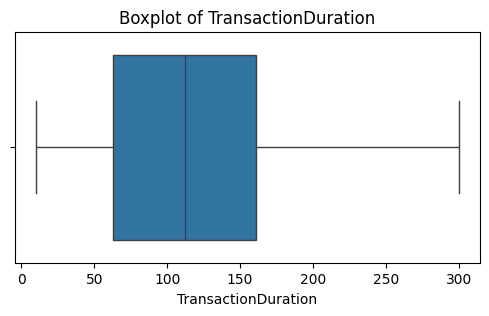

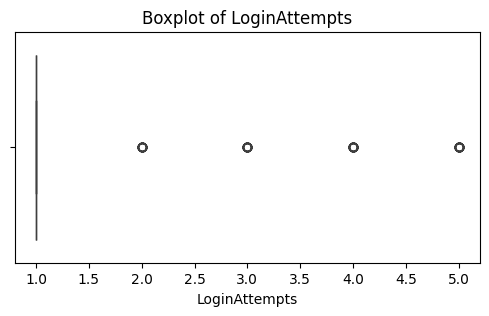

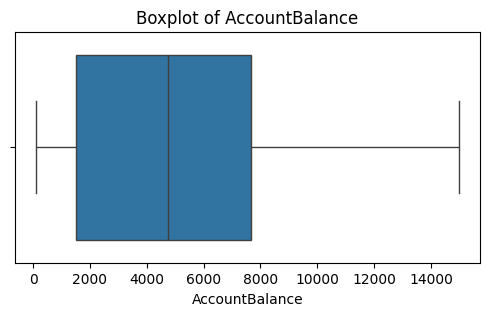

In [63]:
# outliers 
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

##### Comments on distributions, skewness, and outliers:
| Field               | Distribution Shape       | Skewness | Outliers                  | Comments                                                                 |
|--------------------|------------------------|----------|---------------------------|-------------------------------------------------------------------------|
| TransactionAmount    | Right-skewed            | 1.74     | Many above upper whisker  | Most transactions are small; a few very large amounts cause right skew. |
| CustomerAge          | Unimodal, roughly normal | 0.15     | None                      | Age distribution is within expected business range (18–80).             |
| TransactionDuration  | Slightly right-skewed    | 0.60     | None                      | Durations vary moderately; no abnormal values detected.                 |
| LoginAttempts        | Right-skewed, peak at 1  | 5.17     | None                      | Most customers have a single login attempt; few have multiple attempts.|
| AccountBalance       | Bimodal                 | 0.60     | None                      | Balances vary naturally; no abnormal values detected.                   |


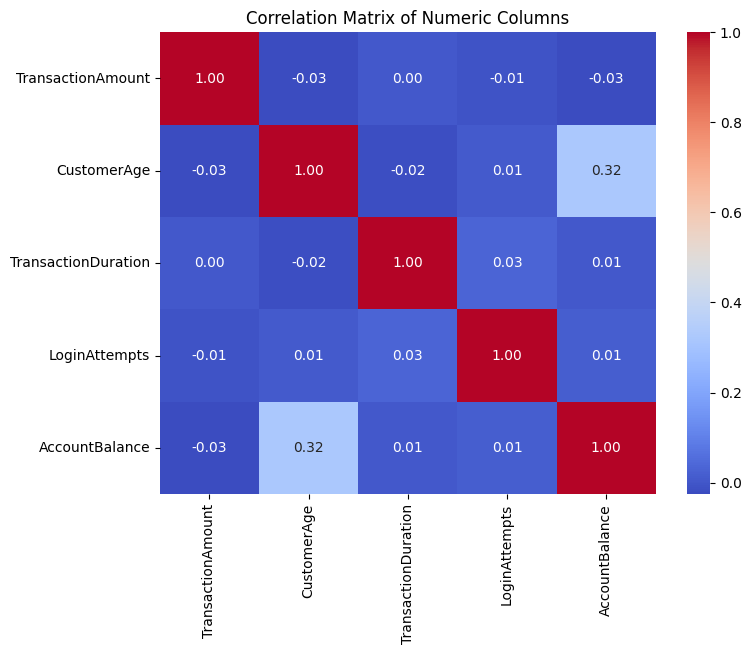

In [64]:
# correlation matrix between numerical fields
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

#### Comments on the correlation:
- Most correlations are very weak (around -0.03 to 0.01), suggesting little linear relationship between most variables.
- The strongest observed correlation is 0.32 between CustomerAge and AccountBalance, indicating a moderate positive relationship in the dataset.
- Correlation of a variable with itself is always 1.0 and should be ignored.

#### 3.2 Categorical columns analysis
Generate value counts, visualize distributions with bar plots, calculate percentage share of each category, and identify rare categories for potential preprocessing.

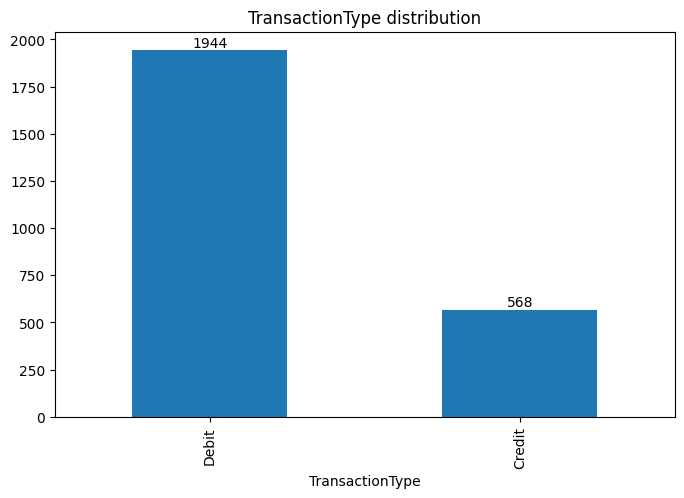

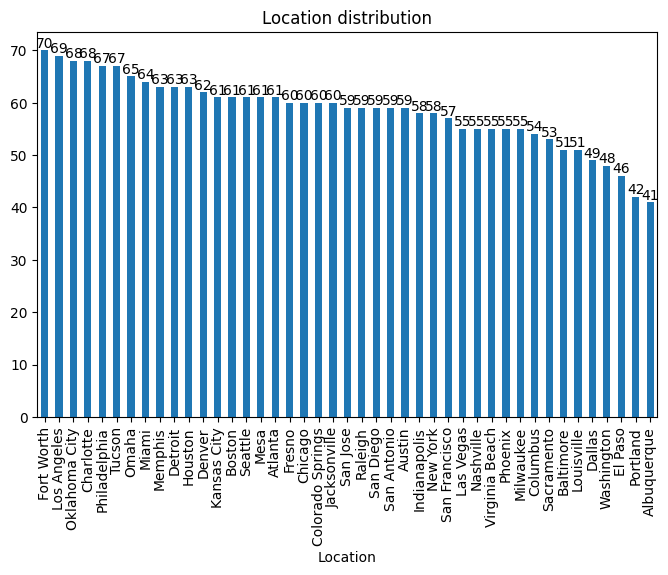

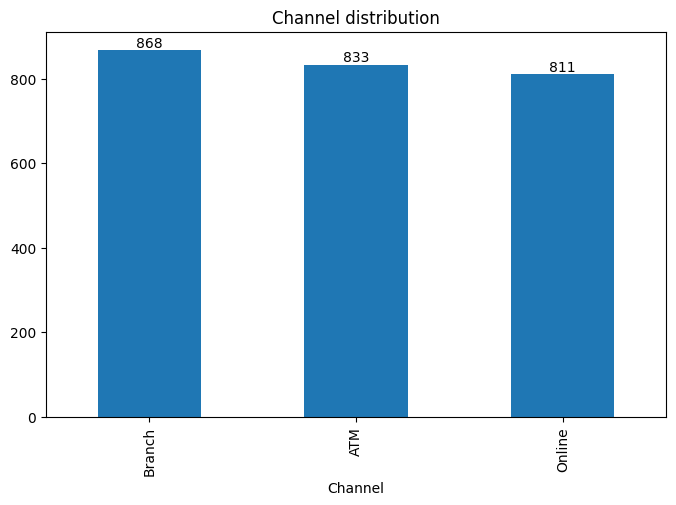

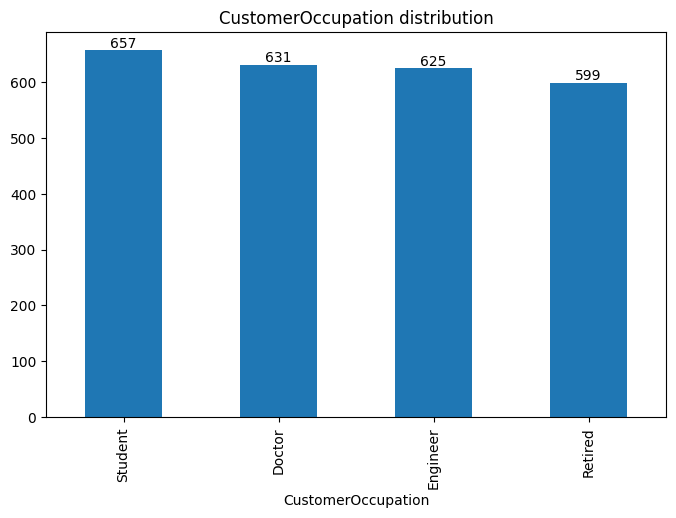

In [65]:
# focus on categorical columns
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
counts_dict = {}

for col in categorical_cols:
    # Save counts in a DataFrame
    counts_df = df[col].value_counts().reset_index()
    counts_df.columns = [col, 'Count']
    counts_dict[col] = counts_df
    
    # Plot with counts on top
    ax = counts_df.plot(kind='bar', x=col, y='Count', legend=False, figsize=(8,5), title=f'{col} distribution')
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10)
    plt.show()

### Step 5: Model Selection & Training

#### 5.1 Isolation Forest (IF)

##### 5.1.1 Model One - using only numeric fields 

Number of normal records (1): 2386
Number of anomalies (-1): 126


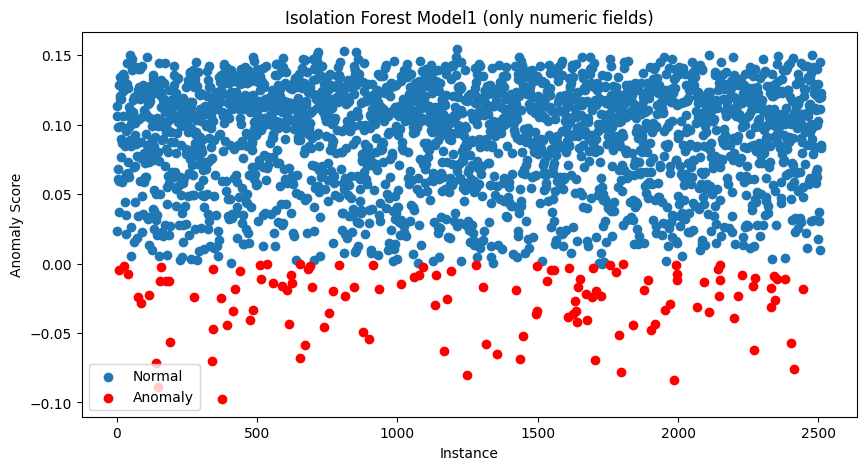

In [66]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

#  copy original dataframe 
df_model = df.copy()

# Select only numeric features, ignore the LoginAttemps because it is highly uniform
numeric_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'AccountBalance']
num_features = df[numeric_cols].copy()

# paramets for the isolation forest models 
iso_forest_model_1 = IsolationForest(
    n_estimators=100, 
    max_samples=256, 
    contamination=0.05, 
    random_state=42
)

# fit and predict, add the results as new column into the dataframe  
iso_forest_model_1.fit(num_features)
df_model['IF_anomaly_model1'] = iso_forest_model_1.predict(num_features)

# counts of normal vs anomaly records 
counts = df_model['IF_anomaly_model1'].value_counts()
print("Number of normal records (1):", counts.get(1, 0))
print("Number of anomalies (-1):", counts.get(-1, 0))

# Visualization of anomaly scores for Model 1
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = df_model[df_model['IF_anomaly_model1'] == 1]
plt.scatter(normal.index, iso_forest_model_1.decision_function(num_features)[normal.index], 
            label='Normal')

# Plot anomalies
anomalies = df_model[df_model['IF_anomaly_model1'] == -1]
plt.scatter(anomalies.index, iso_forest_model_1.decision_function(num_features)[anomalies.index], 
            label='Anomaly', color='red')

plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.title("Isolation Forest Model1 (only numeric fields)")
plt.legend()
plt.show()

In [67]:
# export anomalies for further examination by domain experts (e.g. auditor, fraud Invistigator)
df_model[df_model['IF_anomaly_model1'] == -1].to_csv("../output/anomalies_model1.csv", index=False)

##### 5.1.2 Model Two - using both numeric and categorical fields
This model uses the following input features:
1. Numeric columns: TransactionAmount, CustomerAge, TransactionDuration, AccountBalance
2. Categorical columns: TransactionType, Location, Channel, CustomerOccupation (identified as relevant during Step 3 – EDA)

Number of normal records (1): 2386
Number of anomalies (-1): 126


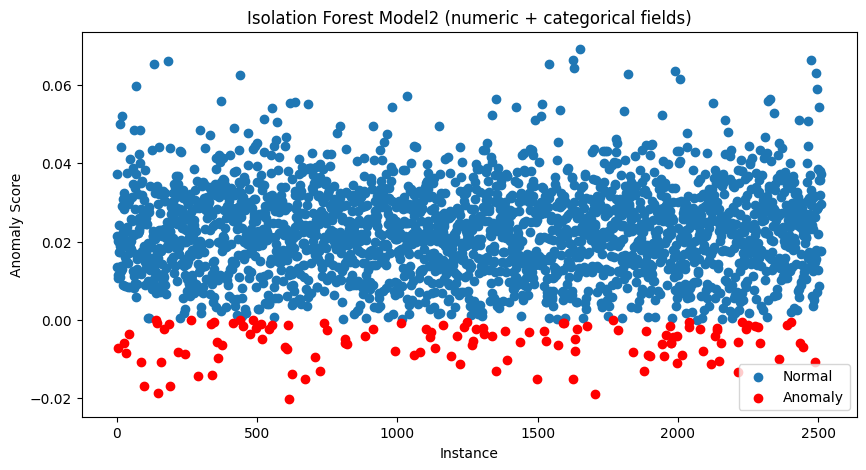

In [68]:
from sklearn.preprocessing import OneHotEncoder

# Define categorical columns
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  
encoded_cat = encoder.fit_transform(df_model[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols), index=df_model.index)

# Combine numeric and encoded categorical features
features_model2 = pd.concat([df_model[numeric_cols], encoded_cat_df], axis=1)

# Initialize Isolation Forest for Model 2
iso_forest_model2 = IsolationForest(
    n_estimators=100,
    max_samples=256,
    contamination=0.05,
    random_state=42
)

# Fit and predict
iso_forest_model2.fit(features_model2)
df_model['IF_anomaly_model2'] = iso_forest_model2.predict(features_model2)

# Counts of normal vs anomaly records
counts = df_model['IF_anomaly_model2'].value_counts()
print("Number of normal records (1):", counts.get(1, 0))
print("Number of anomalies (-1):", counts.get(-1, 0))

# Visualization of anomaly scores for Model 2
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = df_model[df_model['IF_anomaly_model2'] == 1]
plt.scatter(normal.index, iso_forest_model2.decision_function(features_model2)[normal.index], 
            label='Normal')

# Plot anomalies
anomalies = df_model[df_model['IF_anomaly_model2'] == -1]
plt.scatter(anomalies.index, iso_forest_model2.decision_function(features_model2)[anomalies.index], 
            label='Anomaly', color='red')

plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.title("Isolation Forest Model2 (numeric + categorical fields)")
plt.legend()
plt.show()


In [70]:
# Extra step: Count records where the anomaly flags differ between Model 1 and Model 2
mismatch_count = (df_model['IF_anomaly_model1'] != df_model['IF_anomaly_model2']).sum()
print("Number of records with different anomaly flags between Model 1 and Model 2:", mismatch_count)

Number of records with different anomaly flags between Model 1 and Model 2: 162


#### 5.2 One-Class Support Vector Machine (SVM)

In [85]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM

# Our input features 
numeric_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'AccountBalance']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

# Preprocessing for our features 
# 1. Standardize numeric features: mean 0, keeping the distribution shape
# 2. OneHotEncode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Preprocessing + One-Class SVM pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('ocsvm', OneClassSVM(kernel='rbf', nu=0.05, gamma='scale'))
])

# Fit model on the features
X = df_model[numeric_cols + categorical_cols]  # use df_model instead of df
svm_pipeline.fit(X)

# Predict anomalies (-1 = anomaly, 1 = normal)
pred_labels = svm_pipeline.predict(X)

# Add SVM anomaly flag to df_model
df_model['SVM_anomaly'] = pred_labels

# Summary
n_anomalies = (df_model['SVM_anomaly'] == -1).sum()
print(f"Total anomalies detected by One-Class SVM: {n_anomalies}")


Total anomalies detected by One-Class SVM: 130


#### 5.3 Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In [93]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN

# Input features
numeric_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'AccountBalance']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

# Preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Preprocess features
X_preprocessed = preprocessor.fit_transform(df_model[numeric_cols + categorical_cols])

# Fit DBSCAN
dbscan_model = DBSCAN(eps=1.5, min_samples=5)  # You may adjust eps and min_samples
dbscan_labels = dbscan_model.fit_predict(X_preprocessed)

# Add anomaly flag to df_model: -1 = anomaly, 1 = normal
df_model['DBSCAN_anomaly'] = [ -1 if x == -1 else 1 for x in dbscan_labels ]

# Summary
n_anomalies_dbscan = (df_model['DBSCAN_anomaly'] == -1).sum()
print(f"Total anomalies detected by DBSCAN: {n_anomalies_dbscan}")


Total anomalies detected by DBSCAN: 1355


This is a large number of anomalies (total 1355 out of 2512 records), here we will try to tune the parameters for the model, mainly selecting an appropriate:
- eps: The maximum distance between two points for them to be considered neighbors.
- min_samples: The minimum number of points required to form a dense region (cluster).
We will be using the k-distance plot and anomaly count plots to achieve a reasonable number of anomalies.

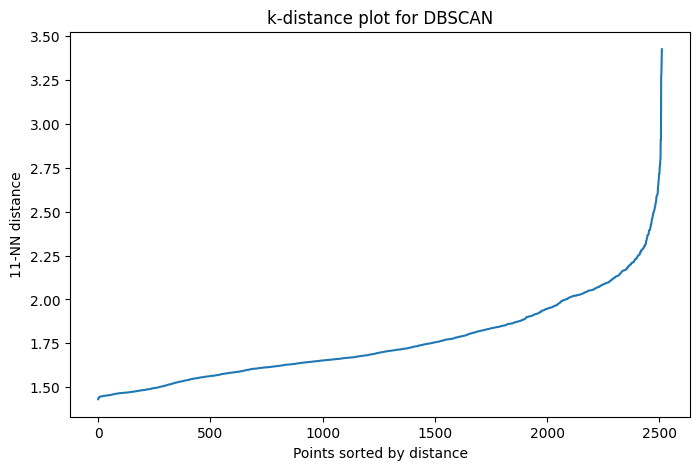

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Determine eps using k-distance plot
min_samples = 11 

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_preprocessed)
distances, indices = neighbors_fit.kneighbors(X_preprocessed)
distances = np.sort(distances[:, -1])  # distance to k-th nearest neighbor

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("k-distance plot for DBSCAN")
plt.show()

From the plot, we can see the 'elbow' point, or sharp increase in the distance between points clustered together, is around 2.25. We will pick values around this point and experiment with the DBSCAN results.

In [112]:
new_eps = 2.0
new_samples = 11

dbscan_model = DBSCAN(eps=new_eps, min_samples=new_samples)
dbscan_labels = dbscan_model.fit_predict(X_preprocessed)
df_model['DBSCAN_anomaly'] = [ -1 if x == -1 else 1 for x in dbscan_labels ]
n_anomalies_dbscan = (df_model['DBSCAN_anomaly'] == -1).sum()
print(f"Total anomalies detected by DBSCAN: {n_anomalies_dbscan}")

Total anomalies detected by DBSCAN: 129


In [113]:
# update my model for the optimal eps and sample size 
# Fit DBSCAN
dbscan_model = DBSCAN(eps=2.0, min_samples=11)  # updated parameters
dbscan_labels = dbscan_model.fit_predict(X_preprocessed)

# Add anomaly flag to df_model: -1 = anomaly, 1 = normal
df_model['DBSCAN_anomaly'] = [-1 if x == -1 else 1 for x in dbscan_labels]

# Summary
n_anomalies_dbscan = (df_model['DBSCAN_anomaly'] == -1).sum()
print(f"Total anomalies detected by DBSCAN: {n_anomalies_dbscan}")

Total anomalies detected by DBSCAN: 129


#### 5.4 Local Outlier Factor (LOF)

In [128]:
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF
lof_model = LocalOutlierFactor(n_neighbors=11, contamination=0.05)  # adjust contamination as needed
lof_labels = lof_model.fit_predict(X_preprocessed)

# Add anomaly flag to df_model: -1 = anomaly, 1 = normal
df_model['LOF_anomaly'] = [ -1 if x == -1 else 1 for x in lof_labels ]

# Summary
n_anomalies_lof = (df_model['LOF_anomaly'] == -1).sum()
print(f"Total anomalies detected by LOF: {n_anomalies_lof}")


Total anomalies detected by LOF: 126


### Step 6: Models Evaluation
The dataset is unlabeled, so standard metrics (precision, recall, F1-score, ROC-AUC) cannot be used. Performance is assessed using:
- The number of anomalies detected (-1 vs 1).
- Domain expert validation to confirm flagged anomalies.
- Although most models detected a similar number of anomalies, the following plots highlight differences in anomaly detection (anomalies are shown in red).

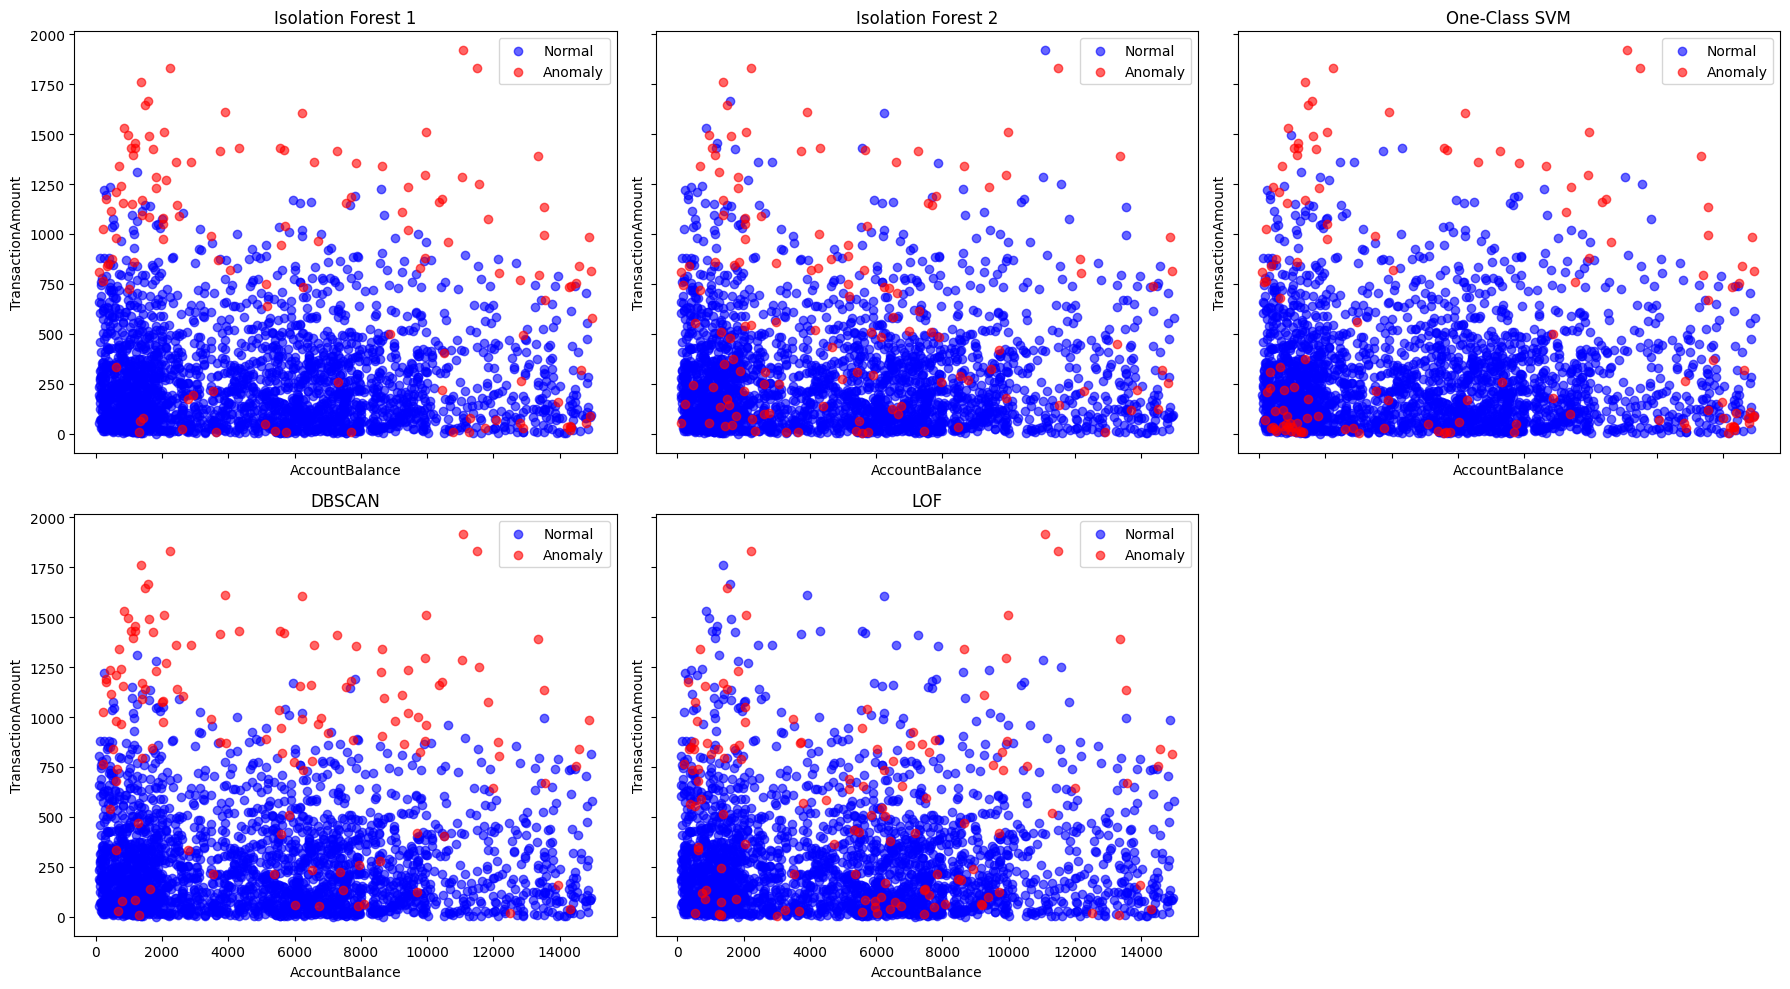

In [ ]:
import matplotlib.pyplot as plt

x_col = 'AccountBalance'
y_col = 'TransactionAmount'

# Reordered list of models
models = [
    ('Isolation Forest 1', 'IF_anomaly_model1'),
    ('Isolation Forest 2', 'IF_anomaly_model2'),
    ('One-Class SVM', 'SVM_anomaly'),
    ('DBSCAN', 'DBSCAN_anomaly'),
    ('LOF', 'LOF_anomaly')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (title, col) in zip(axes, models):
    normal = df_model[df_model[col] == 1]
    anomaly = df_model[df_model[col] == -1]
    
    ax.scatter(normal[x_col], normal[y_col], c='blue', label='Normal', alpha=0.6)
    ax.scatter(anomaly[x_col], anomaly[y_col], c='red', label='Anomaly', alpha=0.6)
    
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()

# Hide the empty subplot if any
if len(models) < len(axes):
    for ax in axes[len(models):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


### Step 7: Conclusion & Future Work
- Export detected anomalies for further analysis.
- Validate anomalies with domain experts to build model trust.
- Consider additional feature engineering (e.g., derived metrics, temporal features) to improve model performance.